# Pneumonia CNN Baseline
Clean multi‑cell notebook version

In [31]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
tf.random.set_seed(SEED)

DATA_DIR = "chest_xray"
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dir = os.path.join(DATA_DIR, "train")
val_dir   = os.path.join(DATA_DIR, "val")
test_dir  = os.path.join(DATA_DIR, "test")

## Load datasets

In [32]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
class_names

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


['NORMAL', 'PNEUMONIA']

In [33]:
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

## Data augmentation

In [34]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

## Build CNN model

In [35]:
def build_cnn_model(
    input_shape=IMG_SIZE + (3,),
    num_filters=(16, 32, 64),
    dense_units=64,
    dropout_rate=0.5,
):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0/255)(x)

    for f in num_filters:
        x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model

model = build_cnn_model()
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 160, 160, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 160, 160, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 80, 80, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,257 (110.38 KB)

 Trainable params: 28,033 (109.50 KB)

 Non-trainable params: 224 (896.00 B)

## Class weights

In [36]:
normal_count = 1341
pneu_count = 3875
total = normal_count + pneu_count

class_weight = {
    0: total / (2 * normal_count),
    1: total / (2 * pneu_count),
}
class_weight

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Callbacks

In [37]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_pneumonia_cnn.keras', save_best_only=True),
]

## Train

In [38]:
# EPOCHS = 10

# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS,
#     class_weight=class_weight,
#     callbacks=callbacks,
# )

## Evaluate on test set

In [39]:
test_metrics = model.evaluate(test_ds)
list(zip(model.metrics_names, test_metrics))

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.3750 - auc_6: 0.5910 - loss: 0.6968 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00


[('loss', 0.6968420147895813), ('compile_metrics', 0.375)]

Quick test: comparing different CNN depths

This section runs a small comparison to see how the number of conv–pool blocks affects model performance. All other settings (optimizer, augmentation, dropout, batch size, etc.) are kept the same so that depth is the only variable being changed.

The three architectures tested are:

1 block: (32,) – very shallow

2 blocks: (32, 64) – lightweight baseline

3 blocks: (32, 64, 128) – slightly deeper

Since the aim is just to compare behaviour rather than fully train each model, the runs are limited to 5 epochs with EarlyStopping enabled. The key things being observed are:

differences in validation accuracy and validation loss

whether deeper models begin to overfit sooner

the change in training time per epoch across depths

The depth that performs best here will be used as the recommended architecture for the final combined model later in the project.

In [40]:
EPOCHS_DEPTH = 5  # small, just to compare

depth_configs = {
    "1_block": (16,),
    "2_blocks": (16, 32),
    "3_blocks": (16, 32, 64),
}

histories = {}

for name, filters in depth_configs.items():
    print(f"\n=== Training model: {name} with filters {filters} ===")
    
    model = build_cnn_model(num_filters=filters)
    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=2, restore_best_weights=True
        ),
    ]
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_DEPTH,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1,
    )
    histories[name] = history



=== Training model: 1_block with filters (16,) ===
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 591ms/step - accuracy: 0.3461 - auc_7: 0.6878 - loss: 0.6781 - precision_7: 0.8919 - recall_7: 0.1363 - val_accuracy: 0.5625 - val_auc_7: 0.6406 - val_loss: 0.6911 - val_precision_7: 1.0000 - val_recall_7: 0.1250
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 512ms/step - accuracy: 0.4599 - auc_7: 0.7825 - loss: 0.6591 - precision_7: 0.9600 - recall_7: 0.2849 - val_accuracy: 0.5000 - val_auc_7: 0.6562 - val_loss: 0.6916 - val_precision_7: 0.5000 - val_recall_7: 0.6250
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 432ms/step - accuracy: 0.5587 - auc_7: 0.8113 - loss: 0.6417 - precision_7: 0.9528 - recall_7: 0.4271 - val_accuracy: 0.6250 - val_auc_7: 0.5938 - val_loss: 0.6899 - val_precision_7: 1.0000 - val_recall_7: 0.2500
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 618ms/step - accuracy: 0.6394 - auc_7: 0.8337 - loss: 0.6207 - precision_7: 0.9594 - recall_7: 0.5373 - val_accuracy: 0.6250 - val_auc_

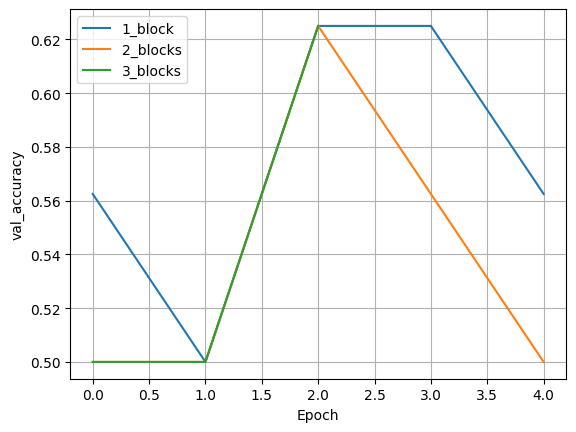

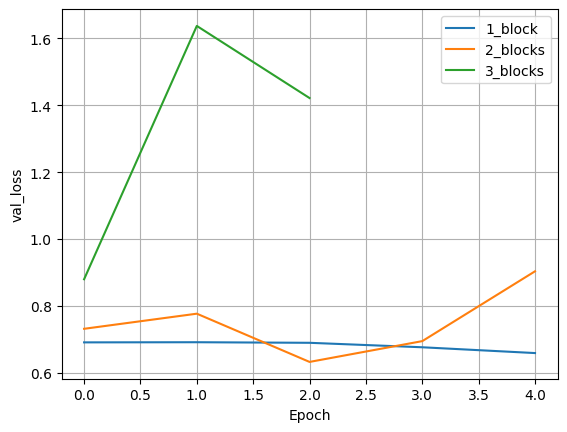

1_block: best val_acc=0.6250, best val_loss=0.6592
2_blocks: best val_acc=0.6250, best val_loss=0.6327
3_blocks: best val_acc=0.6250, best val_loss=0.8799


In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metric(histories, metric="val_accuracy"):
    plt.figure()
    for name, history in histories.items():
        plt.plot(history.history[metric], label=name)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(histories, "val_accuracy")
plot_metric(histories, "val_loss")

for name, history in histories.items():
    val_acc = history.history["val_accuracy"]
    val_loss = history.history["val_loss"]
    print(
        f"{name}: best val_acc={np.max(val_acc):.4f}, "
        f"best val_loss={np.min(val_loss):.4f}"
    )
